# Loan Default Classification
#### CHAPTER 11: _Bias Mitigation and Causal Inference Methods_
##### From **Interpretable Machine Learning with Python 2nd Edition** by Serg Masís, published by Packt

## The Preparations

### Installing the Libraries

The following cell checks if the libraries required by this chapter are installed and installs them **ONLY** if they aren't. Please note that this step is not necessary if you have already installed ALL libraries required by the entire book with the [setup.py](../setup.py) script for the entire book. Instructions to do this are in the [README.md](../README.md).

In [ ]:
!python chapter_setup.py

### Loading the Libraries

In [102]:
import math
import os
import warnings
import mldatasets
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn import model_selection, tree, metrics
import lightgbm as lgb
import xgboost as xgb

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import ExponentiatedGradientReduction
from aif360.algorithms.inprocessing import GerryFairClassifier
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from aif360.algorithms.postprocessing.eq_odds_postprocessing import EqOddsPostprocessing
from econml.dr import LinearDRLearner
import dowhy
from dowhy import CausalModel

import xai
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

%matplotlib inline

### Understanding and Preparing the Data

In [2]:
ccdefault_all_df = mldatasets.load("cc-default", prepare=True)

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/cc_defaults_taiwan.csv.zip downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/_packt_git/Interpretable-Machine-Learning-with-Python-2E/11/data/cc_defaults_taiwan.csv.zip
/Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/_packt_git/Interpretable-Machine-Learning-with-Python-2E/11/data/cc_defaults_taiwan.csv.zip uncompressed to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/_packt_git/Interpretable-Machine-Learning-with-Python-2E/11/data/cc_defaults_taiwan.csv
1 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/_packt_git/Interpretable-Machine-Learning-with-Python-2E/11/data/cc_defaults_taiwan.csv folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/_packt_git/Interpretable-Machine-Learning-with-Python-2E/11/data/cc_defaults_taiwan.csv/cc_defaults_new_taiwan.csv


In [3]:
ccdefault_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CC_LIMIT_CAT      30000 non-null  int8   
 1   EDUCATION         30000 non-null  int8   
 2   MARITAL_STATUS    30000 non-null  int8   
 3   GENDER            30000 non-null  int8   
 4   AGE_GROUP         30000 non-null  int8   
 5   pay_status_1      30000 non-null  int8   
 6   pay_status_2      30000 non-null  int8   
 7   pay_status_3      30000 non-null  int8   
 8   pay_status_4      30000 non-null  int8   
 9   pay_status_5      30000 non-null  int8   
 10  pay_status_6      30000 non-null  int8   
 11  paid_pct_1        30000 non-null  float64
 12  paid_pct_2        30000 non-null  float64
 13  paid_pct_3        30000 non-null  float64
 14  paid_pct_4        30000 non-null  float64
 15  paid_pct_5        30000 non-null  float64
 16  paid_pct_6        30000 non-null  float64
 17

In [4]:
ccdefault_all_df._TREATMENT.value_counts()

_TREATMENT
-1    28904
 0      274
 1      274
 2      274
 3      274
Name: count, dtype: int64

#### Data Preparation

In [5]:
ccdefault_bias_df = ccdefault_all_df[ccdefault_all_df._TREATMENT < 1]
ccdefault_causal_df = ccdefault_all_df[ccdefault_all_df._TREATMENT >= 0]

## Detecting Bias

### Visualizing Dataset Bias

In [6]:
ccdefault_bias_df[ccdefault_bias_df.IS_DEFAULT==1].GENDER.\
            value_counts()/ccdefault_bias_df.GENDER.value_counts()

GENDER
2    0.206529
1    0.241633
Name: count, dtype: float64

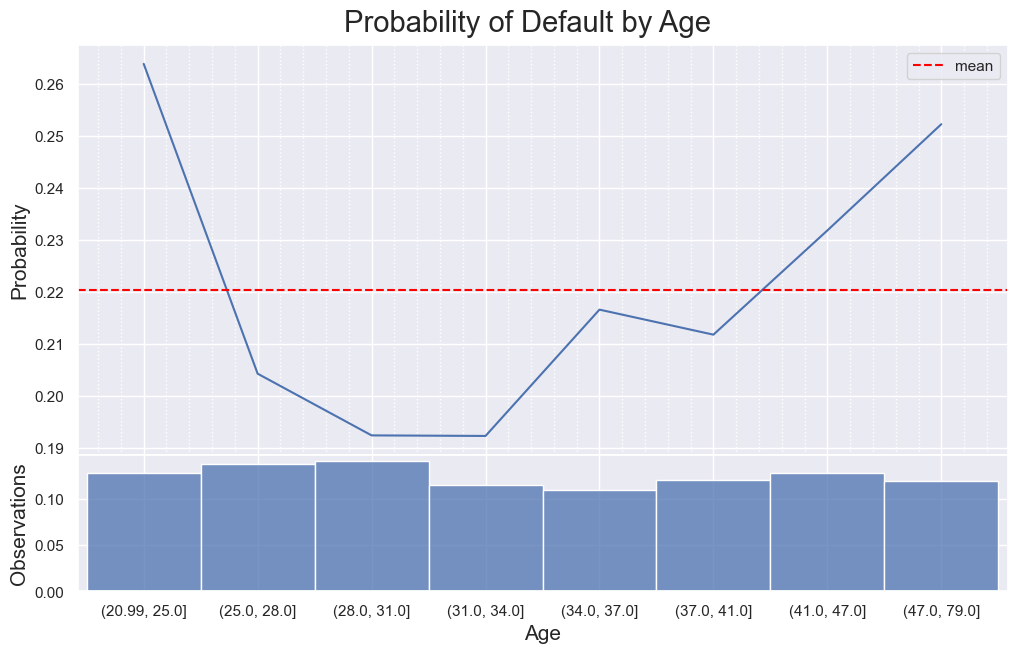

In [7]:
mldatasets.plot_prob_progression(ccdefault_bias_df._AGE, ccdefault_bias_df.IS_DEFAULT,\
                                 x_intervals=8, use_quartiles=True, xlabel='Age',\
                                 title='Probability of Default by Age', mean_line=True)

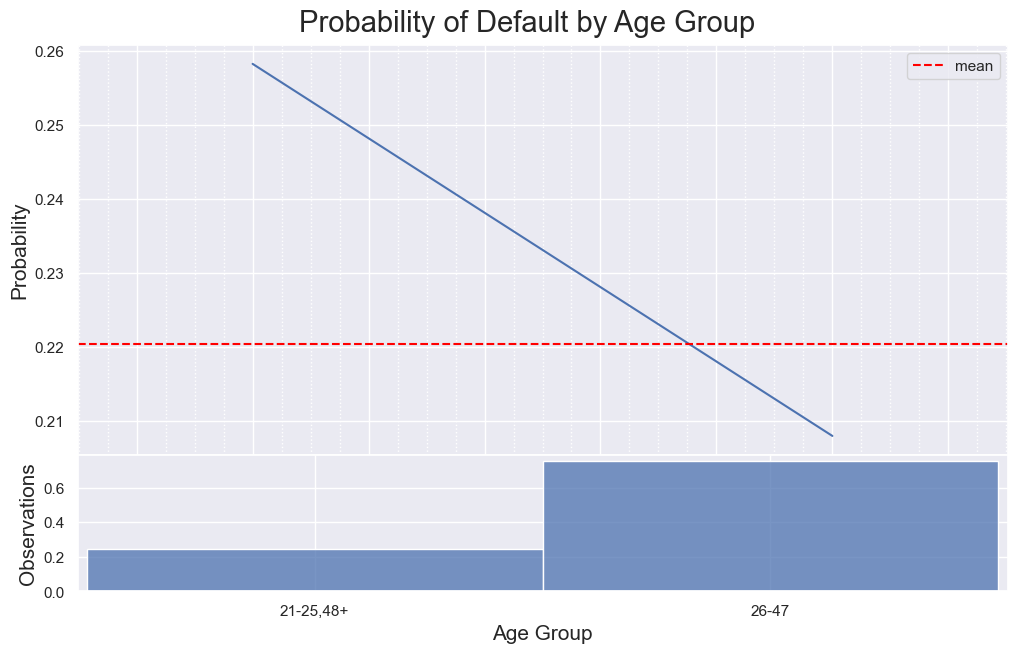

In [8]:
mldatasets.plot_prob_progression(ccdefault_bias_df.AGE_GROUP.replace({0:'21-25,48+',1:'26-47'}),\
                                 ccdefault_bias_df.IS_DEFAULT, xlabel='Age Group',\
                                 title='Probability of Default by Age Group', mean_line=True)

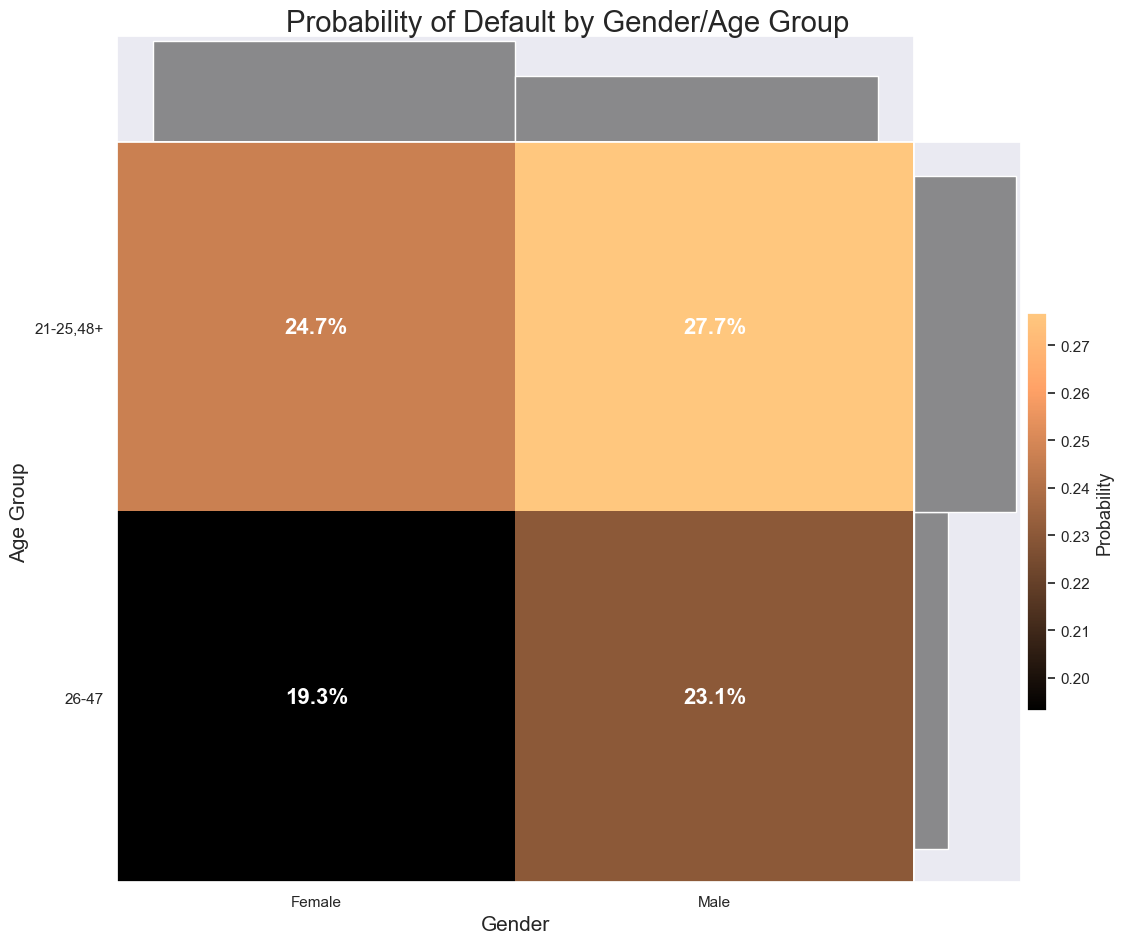

In [9]:
mldatasets.plot_prob_contour_map(ccdefault_bias_df.GENDER.replace({1:'Male',2:'Female'}),\
                      ccdefault_bias_df.AGE_GROUP.replace({0:'21-25,48+',1:'26-47'}),\
                      ccdefault_bias_df.IS_DEFAULT, xlabel='Gender', ylabel='Age Group',\
                    title='Probability of Default by Gender/Age Group', plot_type='grid',\
                    annotate=True, cmap=plt.cm.copper)

### Quantifying Dataset Bias

In [10]:
cols_bias_l =\
    ccdefault_all_df.columns[~ccdefault_all_df.columns.str.startswith('_')].tolist()
cols_causal_l =\
    ['AGE_GROUP','IS_DEFAULT'] +\
    ccdefault_all_df.columns[ccdefault_all_df.columns.str.startswith('_')].tolist()

ccdefault_bias_df = ccdefault_bias_df[cols_bias_l]
ccdefault_causal_df = ccdefault_causal_df[cols_causal_l]

In [11]:
rand = 9
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

y = ccdefault_bias_df['IS_DEFAULT']
X = ccdefault_bias_df.drop(['IS_DEFAULT'], axis=1).copy()
X_train, X_test, y_train, y_test =\
    model_selection.train_test_split(X, y, test_size=0.25, random_state=rand)

In [12]:
train_ds = BinaryLabelDataset(df=X_train.join(y_train),\
                    label_names=['IS_DEFAULT'],\
                    protected_attribute_names=['AGE_GROUP', 'GENDER'],
                    favorable_label=0, unfavorable_label=1)
test_ds = BinaryLabelDataset(df=X_test.join(y_test),\
                    label_names=['IS_DEFAULT'],\
                    protected_attribute_names=['AGE_GROUP', 'GENDER'],
                    favorable_label=0, unfavorable_label=1)

In [13]:
underprivileged_groups=[{'AGE_GROUP': 0}]
privileged_groups=[{'AGE_GROUP': 1}]

metrics_train_ds = BinaryLabelDatasetMetric(train_ds,\
                            unprivileged_groups=underprivileged_groups,\
                            privileged_groups=privileged_groups)
metrics_test_ds = BinaryLabelDatasetMetric(test_ds,\
                            unprivileged_groups=underprivileged_groups,\
                            privileged_groups=privileged_groups)

print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      metrics_train_ds.statistical_parity_difference())
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      metrics_train_ds.disparate_impact())
print('Smoothed Empirical Differential Fairness (SEDF):\t%.4f' %\
      metrics_train_ds.smoothed_empirical_differential_fairness())

Statistical Parity Difference (SPD):			-0.0437
Disparate Impact (DI):					0.9447
Smoothed Empirical Differential Fairness (SEDF):	0.3514


### Quantifying Model Bias

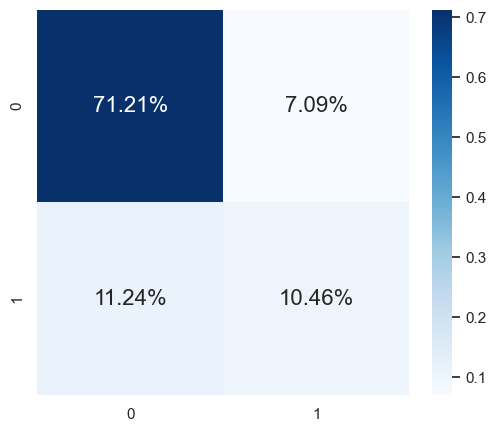

Accuracy_train:  0.8255		Accuracy_test:   0.8167
Precision_test:  0.5961		Recall_test:     0.4820
ROC-AUC_test:    0.7901		F1_test:         0.5330		MCC_test: 0.4243


In [14]:
cls_mdls = {}

lgb_params = {'learning_rate': 0.4, 'reg_alpha': 21, 'reg_lambda': 1,\
          'scale_pos_weight': 1.8}
lgb_base_mdl = lgb.LGBMClassifier(random_seed=rand, max_depth=6,\
                             num_leaves=33, verbose=-1, **lgb_params)
lgb_base_mdl.fit(X_train, y_train)
cls_mdls['lgb_0_base'] =\
    mldatasets.evaluate_class_mdl(lgb_base_mdl,\
            X_train, X_test, y_train, y_test, plot_roc=False,\
            plot_conf_matrix=True, show_summary=True, ret_eval_dict=True)

In [15]:
test_pred_ds = test_ds.copy(deepcopy=True)
test_pred_ds.labels = cls_mdls['lgb_0_base']['preds_test'].reshape(-1,1)
test_pred_ds.scores = cls_mdls['lgb_0_base']['probs_test'].reshape(-1,1)
metrics_test_dict, metrics_test_cls =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_ds,\
                          unprivileged_groups=underprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['lgb_0_base'].update(metrics_test_dict)

print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      metrics_test_cls.statistical_parity_difference())
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      metrics_test_cls.disparate_impact())
print('Average Odds Difference (AOD):\t\t\t\t%.4f' %\
      metrics_test_cls.average_odds_difference())
print('Equal Opportunity Difference (EOD):\t\t\t%.4f' %\
      metrics_test_cls.equal_opportunity_difference())
print('Differential Fairness Bias Amplification (DFBA):\t%.4f' %\
      metrics_test_cls.differential_fairness_bias_amplification())

Statistical Parity Difference (SPD):			-0.0679
Disparate Impact (DI):					0.9193
Average Odds Difference (AOD):				-0.0550
Equal Opportunity Difference (EOD):			-0.0265
Differential Fairness Bias Amplification (DFBA):	0.2328


## Mitigating Bias

### Pre-processing Bias Mitigation Methods

#### Reweighting Method

In [16]:
reweighter = Reweighing(unprivileged_groups=underprivileged_groups,\
                        privileged_groups=privileged_groups)
reweighter.fit(train_ds)
train_rw_ds = reweighter.transform(train_ds)

In [17]:
metrics_train_rw_ds = BinaryLabelDatasetMetric(train_rw_ds,\
                            unprivileged_groups=underprivileged_groups,\
                            privileged_groups=privileged_groups)

print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      metrics_train_rw_ds.statistical_parity_difference())
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      metrics_train_rw_ds.disparate_impact())
print('Smoothed Empirical Differential Fairness (SEDF):\t%.4f' %\
      metrics_train_rw_ds.smoothed_empirical_differential_fairness())

Statistical Parity Difference (SPD):			-0.0000
Disparate Impact (DI):					1.0000
Smoothed Empirical Differential Fairness (SEDF):	0.1942


In [18]:
np.abs(train_ds.instance_weights.mean() - train_rw_ds.instance_weights.mean()) < 1e-6

True

In [19]:
lgb_rw_mdl = lgb.LGBMClassifier(random_seed=rand, max_depth=6,\
                             num_leaves=33, verbose=-1, **lgb_params)
lgb_rw_mdl.fit(X_train, y_train,
              sample_weight=train_rw_ds.instance_weights)

LGBMClassifier(learning_rate=0.4, max_depth=6, num_leaves=33, random_seed=9,
               reg_alpha=21, reg_lambda=1, scale_pos_weight=1.8)

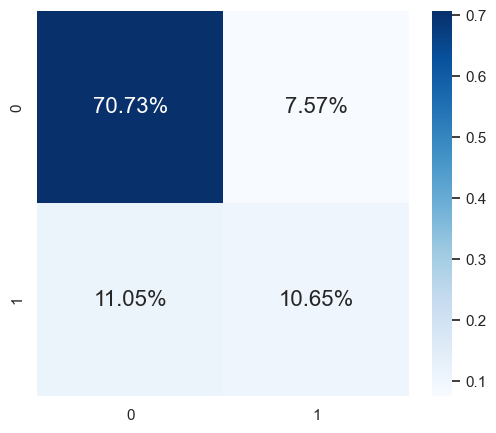

Accuracy_train:  0.8240		Accuracy_test:   0.8138
Precision_test:  0.5847		Recall_test:     0.4908
ROC-AUC_test:    0.7886		F1_test:         0.5337		MCC_test: 0.4210


In [20]:
cls_mdls['lgb_1_rw'] =\
    mldatasets.evaluate_class_mdl(lgb_rw_mdl,\
            train_rw_ds.features, X_test, train_rw_ds.labels, y_test,\
            plot_roc=False, plot_conf_matrix=True, show_summary=True,\
            ret_eval_dict=True)

test_pred_rw_ds = test_ds.copy(deepcopy=True)
test_pred_rw_ds.labels = cls_mdls['lgb_1_rw']['preds_test'].reshape(-1,1)
test_pred_rw_ds.scores = cls_mdls['lgb_1_rw']['probs_test'].reshape(-1,1)
metrics_test_rw_dict, _ =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_rw_ds,\
                          unprivileged_groups=underprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['lgb_1_rw'].update(metrics_test_rw_dict)

#### Disparate Impact Remover Method

In [21]:
protected_index = train_ds.feature_names.index('AGE_GROUP')

In [22]:
di = np.array([])
train_dir_ds = None
test_dir_ds = None
lgb_dir_mdl = None
X_train_dir = None
X_test_dir = None

levels = np.hstack([np.linspace(0., 0.1, 41), np.linspace(0.2, 1, 9)])

for level in tqdm(levels):
    di_remover = DisparateImpactRemover(repair_level=level)
    train_dir_ds_i = di_remover.fit_transform(train_ds)
    test_dir_ds_i = di_remover.fit_transform(test_ds)
    
    X_train_dir_i = np.delete(train_dir_ds_i.features, protected_index, axis=1)
    X_test_dir_i = np.delete(test_dir_ds_i.features, protected_index, axis=1)
    
    lgb_dir_mdl_i = lgb.LGBMClassifier(random_seed=rand, max_depth=5,\
                             num_leaves=33, verbose=-1, **lgb_params)
    lgb_dir_mdl_i.fit(X_train_dir_i, train_dir_ds_i.labels)
    
    test_dir_ds_pred_i = test_dir_ds_i.copy()
    test_dir_ds_pred_i.labels = lgb_dir_mdl_i.predict(X_test_dir_i)
    metrics_test_dir_ds = BinaryLabelDatasetMetric(test_dir_ds_pred_i,\
                                   unprivileged_groups=underprivileged_groups,\
                                   privileged_groups=privileged_groups)
    di_i = metrics_test_dir_ds.disparate_impact()
    
    if (di.shape[0]==0) or (np.min(np.abs(di-1)) >= abs(di_i-1)):
        print(abs(di_i-1))
        train_dir_ds = train_dir_ds_i
        test_dir_ds = test_dir_ds_i
        X_train_dir = X_train_dir_i
        X_test_dir = X_test_dir_i
        lgb_dir_mdl = lgb_dir_mdl_i
        
    di = np.append(np.array(di), di_i)

  0%|          | 0/50 [00:00<?, ?it/s]

0.0848151190044345
0.07846267133852836
0.0755038831411462
0.07481081731642347


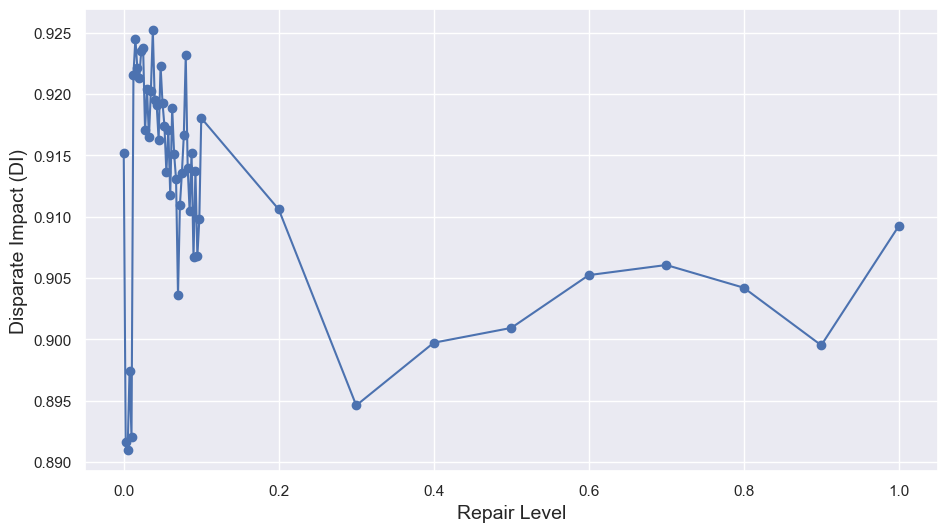

In [23]:
%matplotlib inline
sns.set()
plt.figure(figsize=(11,6))
plt.plot(levels, di, marker='o')
plt.ylabel('Disparate Impact (DI)', fontsize=14)
plt.xlabel('Repair Level', fontsize=14)
#plt.xscale('log')
plt.show()

In [24]:
cls_mdls['lgb_1_dir'] =\
    mldatasets.evaluate_class_mdl(lgb_dir_mdl,\
            X_train_dir, X_test_dir, train_dir_ds.labels, test_dir_ds.labels,\
            plot_roc=False, plot_conf_matrix=False, show_summary=False,\
            ret_eval_dict=True)

test_pred_dir_ds = test_ds.copy(deepcopy=True)
test_pred_dir_ds.labels = cls_mdls['lgb_1_dir']['preds_test'].reshape(-1,1)
metrics_test_dir_dict, _ =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_dir_ds,\
                          unprivileged_groups=underprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['lgb_1_dir'].update(metrics_test_dir_dict)

### In-processing Bias Mitigation Methods

#### Exponentiated Gradient Reduction

In [25]:
%%time
lgb_egr_mdl = ExponentiatedGradientReduction(estimator=lgb_base_mdl, max_iter=50,\
                                             constraints='DemographicParity')
lgb_egr_mdl.fit(train_ds)

CPU times: user 1min 32s, sys: 47.2 s, total: 2min 19s
Wall time: 52.3 s


In [26]:
train_pred_egr_ds = lgb_egr_mdl.predict(train_ds)
test_pred_egr_ds = lgb_egr_mdl.predict(test_ds)

cls_mdls['lgb_2_egr'] =\
    mldatasets.evaluate_class_metrics_mdl(lgb_egr_mdl, train_pred_egr_ds.labels,\
                test_pred_egr_ds.scores, test_pred_egr_ds.labels, y_train, y_test)
metrics_test_egr_dict, _ =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_egr_ds,\
                          unprivileged_groups=underprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['lgb_2_egr'].update(metrics_test_egr_dict)

#### GerryFair Classifier Method

In [27]:
dt_gf_mdl = GerryFairClassifier(C=100, gamma=.005, fairness_def='FN',\
                                max_iters=50, printflag=True,\
                                predictor=tree.DecisionTreeRegressor(max_depth=3))

dt_gf_mdl.fit(train_ds, early_termination=True)

iteration: 1, error: 0.17863181465064204, fairness violation: 0.00248572931140393, violated group size: 0.1340309829548051
iteration: 2, error: 0.17863181465064204, fairness violation: 0.00248572931140393, violated group size: 0.1340309829548051
iteration: 3, error: 0.17863181465064204, fairness violation: 0.00248572931140393, violated group size: 0.1340309829548051
iteration: 4, error: 0.17863181465064204, fairness violation: 0.00248572931140393, violated group size: 0.1340309829548051
iteration: 5, error: 0.17863181465064204, fairness violation: 0.00248572931140393, violated group size: 0.1340309829548051


In [28]:
train_pred_gf_ds = dt_gf_mdl.predict(train_ds, threshold=False)
test_pred_gf_ds = dt_gf_mdl.predict(test_ds, threshold=False)
cls_mdls['dt_2_gf'] =\
    mldatasets.evaluate_class_metrics_mdl(dt_gf_mdl, train_pred_gf_ds.labels,\
                                None, test_pred_gf_ds.labels, y_train, y_test)
metrics_test_gf_dict, _ =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_gf_ds,\
                          unprivileged_groups=underprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['dt_2_gf'].update(metrics_test_gf_dict)

### Post-processing Bias Mitigation Methods

#### Equalized Odds Postprocessing Method

In [29]:
## Monkey patch to bug in AIF360's `eq_odds_postprocessing.py` addressed in this commit:
## https://github.com/Trusted-AI/AIF360/pull/458/commits/b5f2c51406acfc35508eb3a7d7ce9cd8b1a1d485
## but at the time of the writing not yet released

# Backup the original numpy `logical_and` function
original_logical_and = np.logical_and

# Create custom `UFunc` class to override the original with
class CustomUFunc_Nin2_Nout1:
    def __init__(self, original_fn):
        self.original_fn = original_fn
        self.nin = 2  # Number of input operands
        self.nout = 1  # Number of output results

    def __call__(self, x1, x2, **kwargs):
        return self.original_fn(x1, x2)
    
    def reduce(self, obj, axis, dtype, out):
        return self.original_fn.reduce(obj, axis, dtype, out)

# Override the numpy `logical_and` function with the custom one
np.logical_and = CustomUFunc_Nin2_Nout1(np.logical_and)

In [32]:
epp = EqOddsPostprocessing(privileged_groups=privileged_groups,\
                           unprivileged_groups=underprivileged_groups)
epp = epp.fit(test_ds, test_pred_ds)
test_pred_epp_ds = roc.predict(test_pred_ds)

In [33]:
cls_mdls['lgb_3_epp'] =\
    mldatasets.evaluate_class_metrics_mdl(lgb_base_mdl, cls_mdls['lgb_0_base']['preds_train'],\
                            test_pred_epp_ds.scores, test_pred_epp_ds.labels, y_train, y_test)
metrics_test_epp_dict, _ =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_epp_ds,\
                          unprivileged_groups=underprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['lgb_3_epp'].update(metrics_test_epp_dict)

#### Calibrated Equalized Odds Postprocessing Method

In [79]:
cpp = CalibratedEqOddsPostprocessing(privileged_groups=privileged_groups,\
                                     unprivileged_groups=underprivileged_groups,\
                                     cost_constraint="fpr",
                                     seed=rand)
cpp = cpp.fit(test_ds, test_pred_ds)
test_pred_cpp_ds = cpp.predict(test_pred_ds)

cls_mdls['lgb_3_cpp'] =\
    mldatasets.evaluate_class_metrics_mdl(lgb_base_mdl, cls_mdls['lgb_0_base']['preds_train'],\
                            test_pred_cpp_ds.scores, test_pred_cpp_ds.labels, y_train, y_test)
metrics_test_cpp_dict, _ =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_cpp_ds,\
                          unprivileged_groups=underprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['lgb_3_cpp'].update(metrics_test_cpp_dict)

### Tying It All Together!

In [68]:
def highlight_top_quantile(s, quantile=0.4):
    s_abs = np.abs(s)
    if quantile > 0:
        threshold = s_abs.quantile(1-quantile)
        is_in_top_quantile = s_abs >= threshold
        is_top = s_abs == s_abs.max()
    else:
        threshold = s_abs.quantile(-quantile)
        is_in_top_quantile = s_abs <= threshold
        is_top = s_abs == s_abs.min()
    qm_z = zip(is_in_top_quantile,is_top)
    return [('background-color: yellow;' if q else '')+\
            ('font-weight:bold' if m else '') for q,m in qm_z]

In [80]:
cls_metrics_df = pd.DataFrame.from_dict(cls_mdls, 'index')\
                    [['accuracy_train', 'accuracy_test', 'f1_test', 'mcc_test',\
                      'SPD', 'DI', 'AOD', 'EOD', 'DFBA']]
metrics_fmt_dict = dict(zip(cls_metrics_df.columns, ['{:.1%}']*3 + ['{:.3f}']*6))

cls_metrics_df.sort_values(by='accuracy_test', ascending=False).style.\
    format(metrics_fmt_dict).\
    apply(highlight_top_quantile, subset=['SPD', 'AOD', 'EOD', 'DFBA'], quantile=-0.4).\
    apply(highlight_top_quantile, subset=['accuracy_test','f1_test','mcc_test','DI'], quantile=0.4)

,accuracy_train,accuracy_test,f1_test,mcc_test,SPD,DI,AOD,EOD,DFBA
dt_2_gf,82.1%,82.6%,48.1%,0.413,-0.055,0.939,-0.043,-0.022,0.252
lgb_0_base,82.6%,81.7%,53.3%,0.424,-0.068,0.919,-0.055,-0.026,0.233
lgb_1_rw,82.4%,81.4%,53.4%,0.421,-0.037,0.955,-0.017,-0.002,0.035
lgb_1_dir,82.4%,81.3%,53.0%,0.417,-0.062,0.925,-0.049,-0.021,0.255
lgb_2_egr,82.7%,81.1%,52.3%,0.410,-0.039,0.953,-0.013,-0.012,-0.082
lgb_3_epp,82.6%,81.1%,51.8%,0.406,-0.026,0.969,-0.001,0.002,-0.014
lgb_3_cpp,82.6%,26.2%,21.3%,-0.306,-0.071,0.761,-0.064,-0.126,0.043


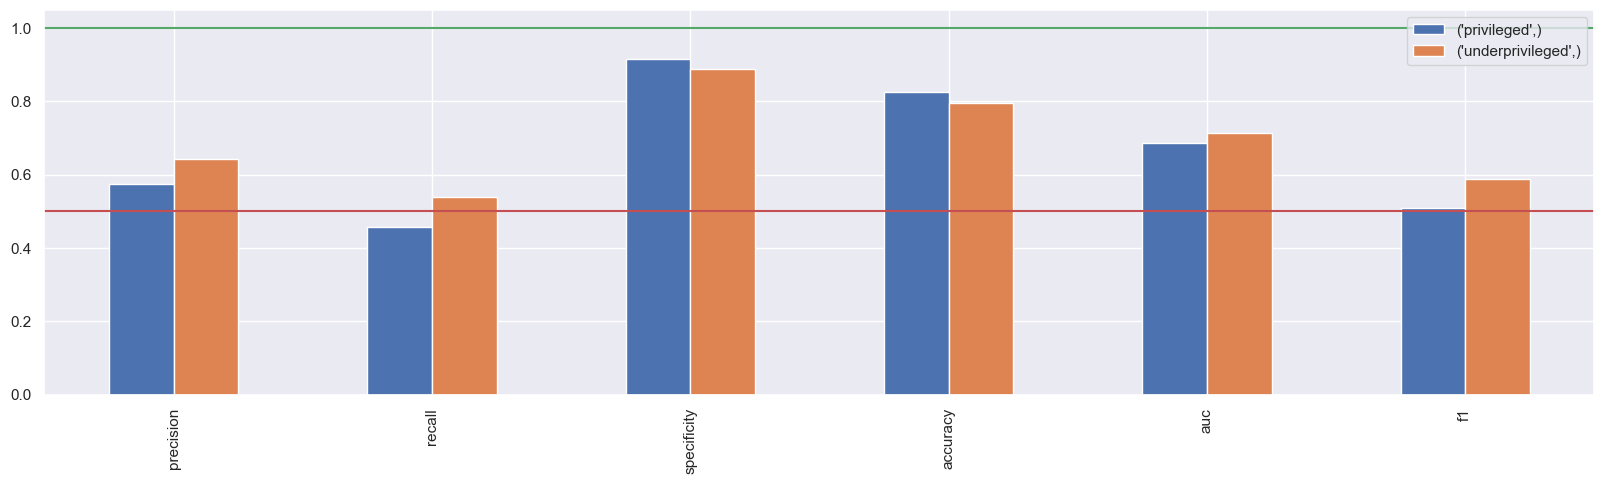

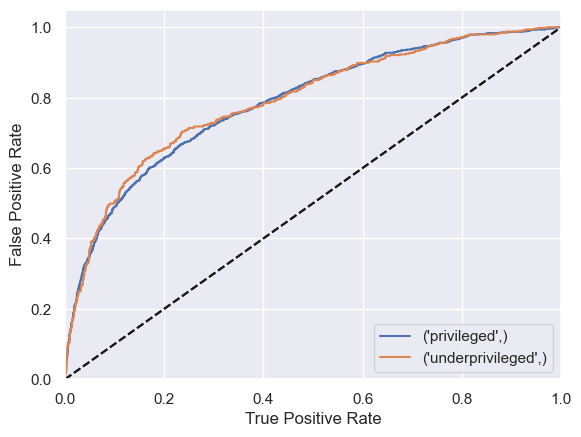

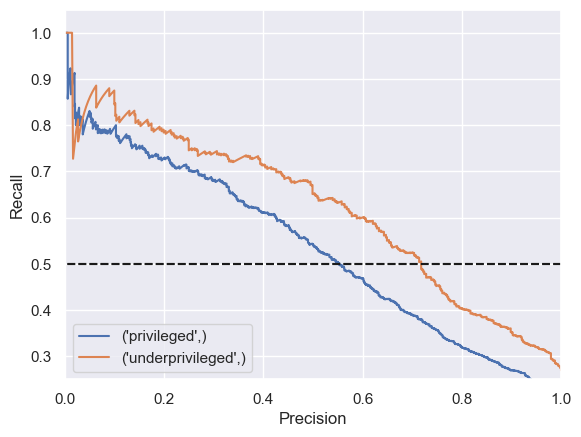

In [81]:
test_df = ccdefault_bias_df.loc[X_test.index]
test_df['AGE_GROUP'] =\
    test_df.AGE_GROUP.replace({0:'underprivileged', 1:'privileged'})
cat_cols_l = ccdefault_bias_df.dtypes[lambda x: x==np.int8].index.tolist()

_ = xai.metrics_plot(
        y_test, cls_mdls['lgb_3_epp']['probs_test'],\
        df=test_df, cross_cols=['AGE_GROUP'],\
        categorical_cols=cat_cols_l)

_ = xai.roc_plot(
        y_test, cls_mdls['lgb_3_epp']['probs_test'],\
        df=test_df, cross_cols=['AGE_GROUP'],\
        categorical_cols=cat_cols_l)

_ = xai.pr_plot(
        y_test, cls_mdls['lgb_3_epp']['probs_test'],\
        df=test_df, cross_cols=['AGE_GROUP'],\
        categorical_cols=cat_cols_l)

## Creating a Causal Model

In [82]:
treatment_names = ['Lower Credit Limit', 'Payment Plan', 'Payment Plan &\nLower Credit Limit']
all_treatment_names = np.array(["None"] + treatment_names)

### Understanding the Results of the Experiment

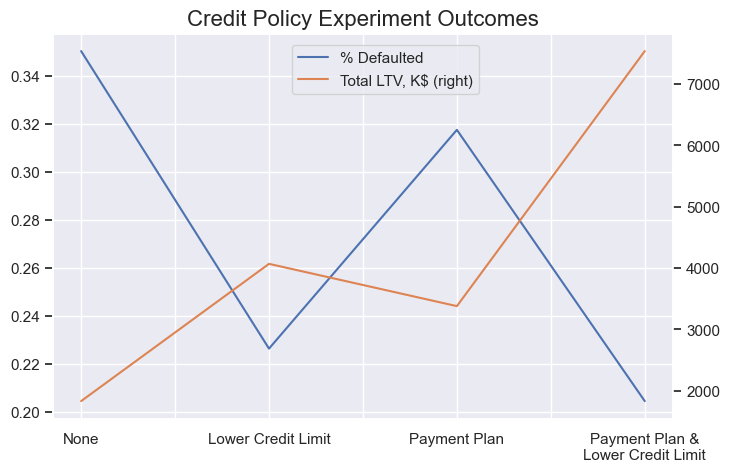

In [83]:
pct_s = ccdefault_causal_df[ccdefault_causal_df.IS_DEFAULT==1].\
                groupby(['_TREATMENT']).size() /\
         ccdefault_causal_df.groupby(['_TREATMENT']).size()
ltv_s = ccdefault_causal_df.groupby(['_TREATMENT'])\
                                            ['_LTV'].sum()/1000
plot_df = pd.DataFrame({'% Defaulted':pct_s, 'Total LTV, K$':ltv_s})
plot_df.index = all_treatment_names

ax = plot_df.plot(secondary_y=['Total LTV, K$'], figsize=(8,5))
ax.get_legend().set_bbox_to_anchor((0.7, 0.99))
plt.grid(False)
plt.title("Credit Policy Experiment Outcomes", fontsize=16)
plt.show()

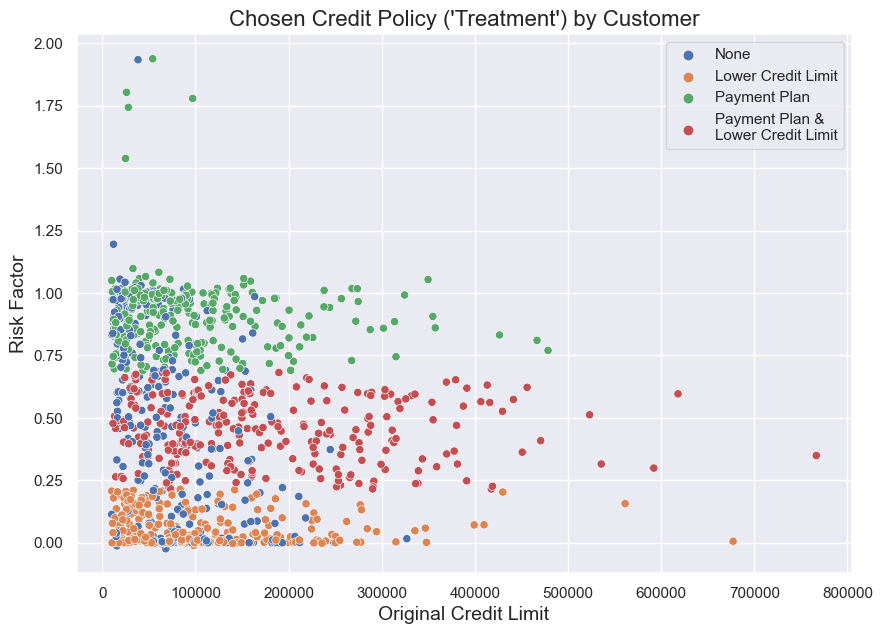

In [84]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=ccdefault_causal_df['_CC_LIMIT'].values,
    y=ccdefault_causal_df['_risk_score'].values,
    hue=all_treatment_names[ccdefault_causal_df['_TREATMENT'].values],
    hue_order=all_treatment_names
)
plt.title("Chosen Credit Policy ('Treatment') by Customer", fontsize=16)
plt.xlabel("Original Credit Limit", fontsize=14)
plt.ylabel("Risk Factor", fontsize=14)
plt.show()

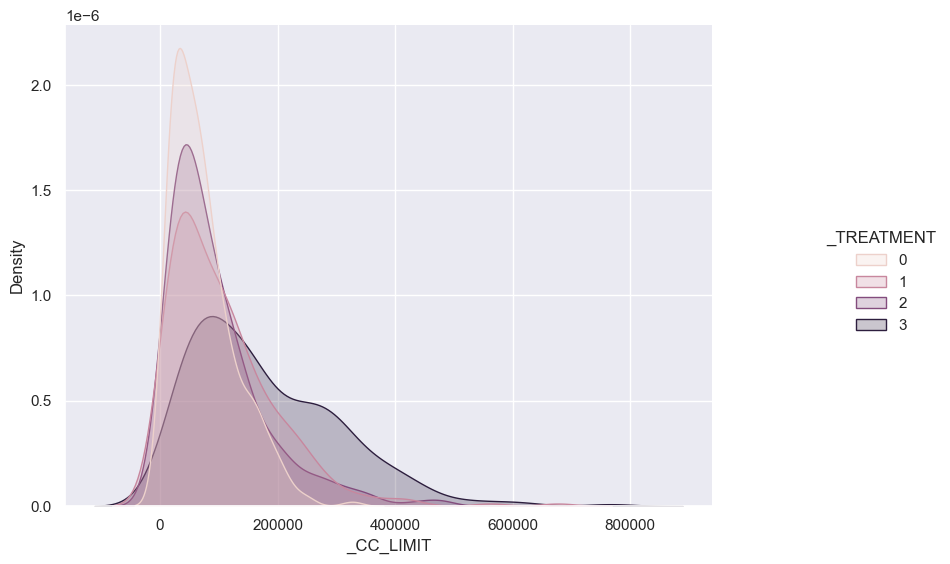

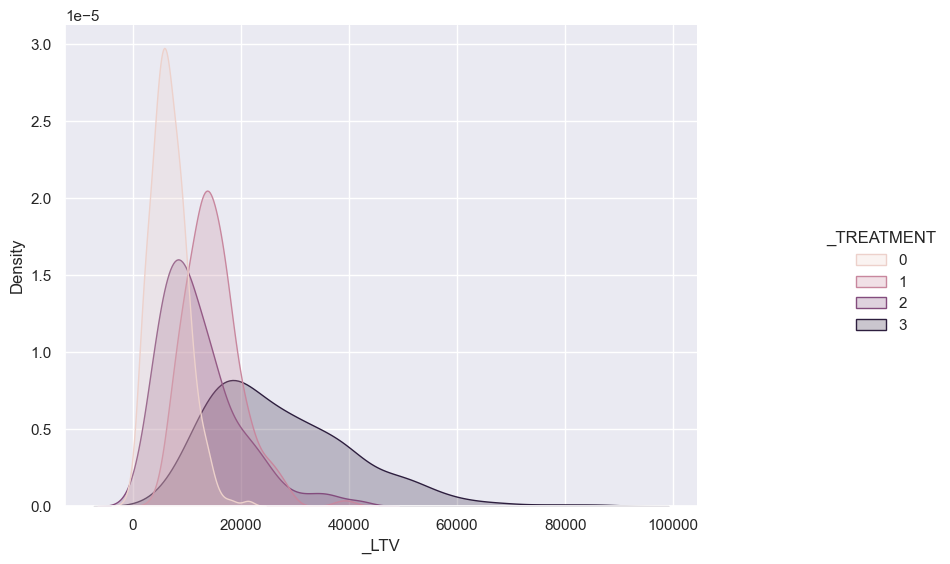

In [85]:
ax = sns.displot(ccdefault_causal_df, x="_CC_LIMIT", hue="_TREATMENT", kind="kde", fill=True)
ax.fig.set_figheight(6)
ax.fig.set_figwidth(10)
ax = sns.displot(ccdefault_causal_df, x="_LTV", hue="_TREATMENT", kind="kde", fill=True)
ax.fig.set_figheight(6)
ax.fig.set_figwidth(10)

### Understanding Causal Models

In [86]:
W = ccdefault_causal_df[['_spend','_tpm','_ppm','_RETAIL','_URBAN','_RURAL','_PREMIUM']]
X = ccdefault_causal_df[['_CC_LIMIT']]
T = ccdefault_causal_df[['_TREATMENT']]
Y = ccdefault_causal_df[['_LTV']]

In [87]:
reg_mdl = xgb.XGBRegressor().fit(W.join(X), Y)
reg_preds = reg_mdl.predict(W.join(X))
print(metrics.mean_squared_error(Y, reg_preds, squared=False))

821.9857550780735


In [88]:
cls_mdl = xgb.XGBClassifier(objective="multi:softmax").fit(W.join(X), T)
cls_preds = cls_mdl.predict(W.join(X))
print(metrics.accuracy_score(T, cls_preds))

1.0


### Initializing the Linear Doubly Robust Learner

In [89]:
drlearner = LinearDRLearner(
                model_regression=xgb.XGBRegressor(learning_rate=0.1),
                model_propensity=xgb.XGBClassifier(learning_rate=0.1, max_depth=2, objective="multi:softmax"),
                random_state=rand,
)

### Fitting the Causal Model

In [90]:
causal_mdl = drlearner.dowhy.fit(Y, T, X=X, W=W, 
                            outcome_names=Y.columns.to_list(), 
                            treatment_names=T.columns.to_list(),
                            feature_names=X.columns.to_list(),
                            confounder_names=W.columns.to_list(), 
                            target_units=X.iloc[:550].values)

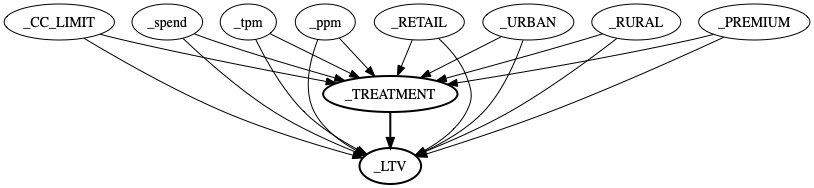

In [71]:
try:
    display(
        Image(to_pydot(causal_mdl._graph._graph).create_png())
    )
except:
    causal_mdl.view_model()

## Understanding Heterogeneous Treatment Effects

In [92]:
identified_ate = causal_mdl.identified_estimand_
print(identified_ate)
drlearner_estimate = causal_mdl.estimate_
print(drlearner_estimate)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(E[_LTV|_URBAN,_tpm,_RETAIL,_RURAL,_CC_LIMIT,_ppm,_spend,_PREMIUM
d[_TREATMENT]                                                                 

  
])
  
Estimand assumption 1, Unconfoundedness: If U→{_TREATMENT} and U→_LTV then P(_LTV|_TREATMENT,_URBAN,_tpm,_RETAIL,_RURAL,_CC_LIMIT,_ppm,_spend,_PREMIUM,U) = P(_LTV|_TREATMENT,_URBAN,_tpm,_RETAIL,_RURAL,_CC_LIMIT,_ppm,_spend,_PREMIUM)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(E[_LTV|_URBAN,_tpm,_RETAIL,_RURAL,_CC_LIMIT,_ppm,_spe

In [93]:
for i in range(causal_mdl._d_t[0]):
    print("Treatment: %s" % treatment_names[i])
    display(causal_mdl.summary(T=i+1))
    print("\r\n") 

Treatment: Lower Credit Limit


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
_CC_LIMIT,0.006,0.02,0.309,0.758,-0.032,0.044
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,6509.016,1311.54,4.963,0.0,3938.444,9079.588




Treatment: Payment Plan


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
_CC_LIMIT,0.042,0.019,2.214,0.027,0.005,0.079
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,1250.946,1223.82,1.022,0.307,-1147.697,3649.588




Treatment: Payment Plan &
Lower Credit Limit


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
_CC_LIMIT,0.068,0.019,3.616,0.0,0.031,0.104
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,5585.943,1237.35,4.514,0.0,3160.782,8011.104


In [94]:
idxs = np.arange(0, causal_mdl._d_t[0])
coefs = np.hstack([causal_mdl.coef_(T=i+1) for i in idxs])
intercepts = np.hstack([causal_mdl.intercept_(T=i+1) for i in idxs])

coefs_err = np.hstack([causal_mdl.coef__interval(T=i+1) for i in idxs])
coefs_err[0, :] = coefs - coefs_err[0, :]
coefs_err[1, :] = coefs_err[1, :] - coefs

intercepts_err = np.vstack(
    [causal_mdl.intercept__interval(T=i+1) for i in idxs]
).T
intercepts_err[0, :] = intercepts - intercepts_err[0, :]
intercepts_err[1, :] = intercepts_err[1, :] - intercepts

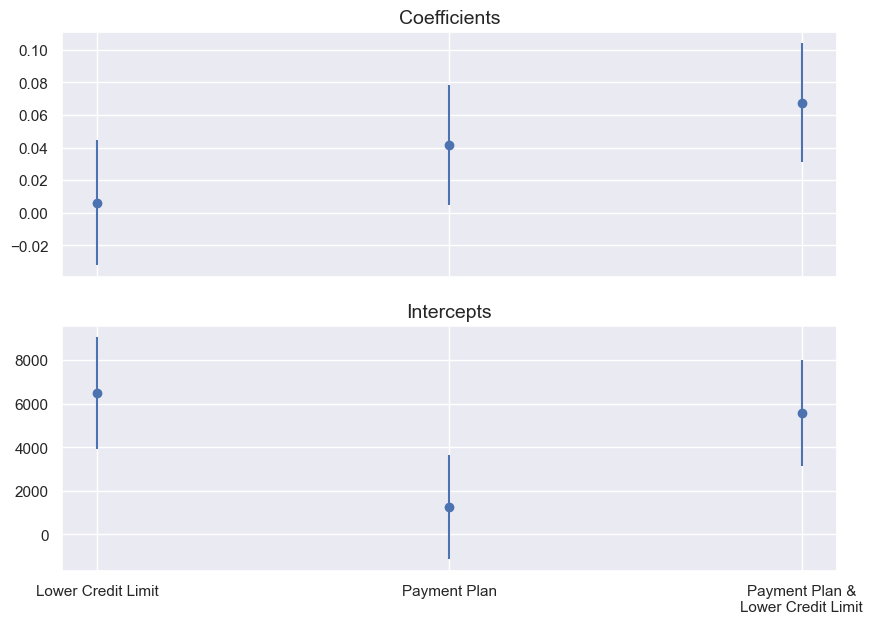

In [95]:
plt.figure(figsize=(10, 7))
ax1 = plt.subplot(2, 1, 1)
plt.errorbar(idxs, coefs, coefs_err, fmt="o")
plt.xticks(idxs, treatment_names)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.title("Coefficients", fontsize=14)

plt.subplot(2, 1, 2)
plt.errorbar(idxs, intercepts, intercepts_err, fmt="o")
plt.xticks(idxs, treatment_names)
plt.title("Intercepts", fontsize=14)
plt.show()

### Choosing Policies

In [96]:
cost_fn = lambda X: np.repeat(np.array([[0, 1000, 1000]]), X.shape[0], axis=0) +\
                    (np.repeat(np.array([[72, 0, 72]]), X.shape[0], axis=0) *\
                     X._ppm.values.reshape(-1,1))

treatment_effect_minus_costs = causal_mdl.const_marginal_effect(X=X.values) -\
                                    cost_fn(ccdefault_causal_df)
treatment_effect_minus_costs = np.hstack([np.zeros(X.shape), treatment_effect_minus_costs])
recommended_T = np.argmax(treatment_effect_minus_costs, axis=1)

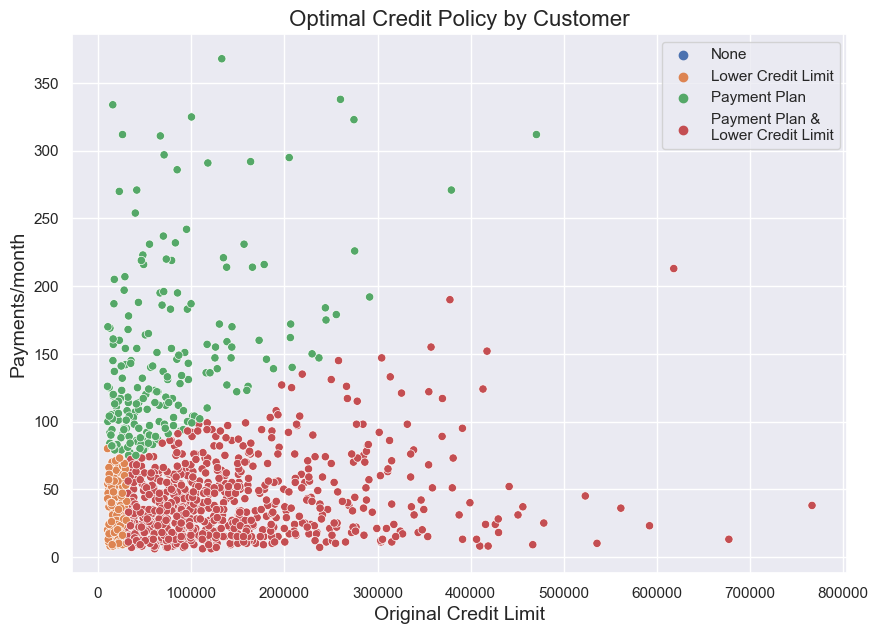

In [97]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=ccdefault_causal_df['_CC_LIMIT'].values,
    y=ccdefault_causal_df["_ppm"].values,
    hue=all_treatment_names[recommended_T],
    hue_order=all_treatment_names
)
plt.title("Optimal Credit Policy by Customer", fontsize=16)
plt.xlabel("Original Credit Limit", fontsize=14)
plt.ylabel("Payments/month", fontsize=14)
plt.show()

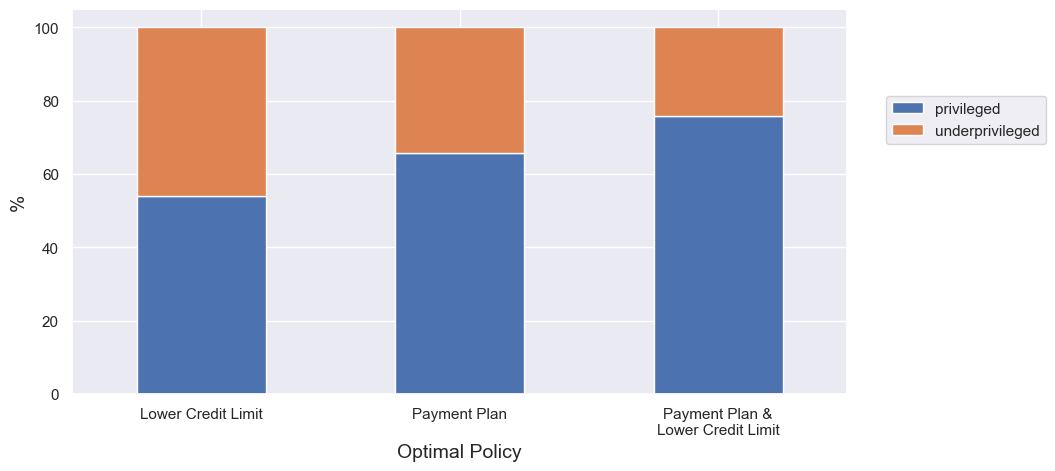

In [98]:
ccdefault_causal_df['recommended_T'] = recommended_T
plot_df = ccdefault_causal_df.groupby(['recommended_T','AGE_GROUP']).\
                                                    size().reset_index()
plot_df['AGE_GROUP'] = plot_df.AGE_GROUP.replace({0:'underprivileged', 1:'privileged'})
plot_df = plot_df.pivot(columns='AGE_GROUP', index='recommended_T', values=0)
plot_df.index = treatment_names
plot_df = plot_df.apply(lambda r: r/r.sum()*100, axis=1)

plot_df.plot.bar(stacked=True, rot=0, figsize=(10,5))
plt.legend(loc=(1.05, 0.65))
plt.xlabel('Optimal Policy', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.show()

## Testing Estimate Robustness

### Adding Random Common Cause

In [99]:
ref_random = causal_mdl.refute_estimate(method_name="random_common_cause")
print(ref_random)

Refute: Add a random common cause
Estimated effect:7190.184200687487
New effect:7208.528267170292
p value:0.94



### Replacing Treatment with a Random Variable

In [100]:
ref_placebo = causal_mdl.refute_estimate(\
                    method_name="placebo_treatment_refuter",\
                    placebo_type="permute", num_simulations=20)
print(ref_placebo)

                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


Refute: Use a Placebo Treatment
Estimated effect:7190.184200687487
New effect:387.34513854457316
p value:0.31842583693589743

